# Manipulating Spatial Data in DuckDB

This notebook demonstrates a complete spatial data workflow to **calculate the ratio of Airbnb listings to total households across Travel-to-Work Areas (TTWAs) in Scotland over time**.

Scotland has 45 TTWAs in total; however, Airbnb listing records are available for only 30 TTWAs, which form the analytical sample used in this notebook.

Temporally, the data cover the period **2020–2023**. All Airbnb listings are aggregated at a **monthly** level to allow for consistent comparison over time.

## Workflow Overview

The analysis follows these key steps:

- Open and query a large volume of Airbnb listing data containing geographic coordinates.
- Construct spatial geometries from latitude and longitude values and transform them into an appropriate coordinate reference system.
- Load the Scottish Intermediate Zone shapefile, which contains household counts.
- Perform a spatial join between Airbnb listings and Intermediate Zones.
- Calculate monthly ratios of Airbnb listings to households for each Intermediate Zone and aggregate results to the Intermediate Zones level.



## Connecting to DuckDB

Let’s start by connecting to a database.  
You can either use an existing DuckDB database file or create an **in-memory** database.

In this notebook, we use **DuckDB’s Python API** rather than the command-line interface.

The workflow is straightforward:
- Create a database connection using `connect`
- Execute SQL queries using `con.sql(<SQL statement>)`

This approach allows us to combine **SQL-based data processing** with **Python-based analysis and visualisation** in a single workflow.

In [2]:
import duckdb as dd

# Create / connect to database
con = dd.connect('my_database_exercise.db')
con.sql('SHOW TABLES;')


┌───────────────────────┐
│         name          │
│        varchar        │
├───────────────────────┤
│ IZs                   │
│ IZs_Gen               │
│ listingGrpMonthly     │
│ listingGrpMonthly_geo │
│ listings              │
│ listings_focus        │
│ listings_proj         │
└───────────────────────┘

## Reading External Files with DuckDB

DuckDB is particularly well suited for working with external data files, such as **JSON** and **Parquet**.

- **JSON** is a semi-structured data format commonly used for web and API data.
- **Parquet** is a columnar storage format designed for very large datasets, often ranging from gigabytes to terabytes.

These formats are widely used in **OLAP systems** and **cloud-based data services**.  
DuckDB’s ability to read, write, and manipulate them efficiently is one of the main reasons for its growing popularity.

In this example, we work with a collection of **Parquet files**, provided in the **Data** folder.

DuckDB can read and combine these files **directly**, without requiring:
- Manual file looping
- Intermediate data loading
- Creation of a large combined file on disk

The queried data can be returned directly as a **Pandas DataFrame**, allowing in-memory analysis and visualisation while maintaining high performance throughout the workflow.

In [18]:
df=con.sql("SELECT * FROM read_parquet('Data/filtered/*.parquet')").df()
print(df.shape)
print(df.columns)

(319304, 73)
Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 

You can directly work with dataframe. But for this DB class, let's create a table and use it for in-DB analysis. 

In [ ]:
con.sql ("drop table listings;")
con.sql("create table listings as SELECT * FROM read_parquet('Data/filtered/*.parquet')")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [3]:
##there is an example of accessing remote data source
##UK's buildings Google-Microsoft-OSM Open Buildings - combined by VIDA - https://source.coop/vida/google-microsoft-osm-open-buildings/geoparquet/by_country
url = "s3://us-west-2.opendata.source.coop/vida/google-microsoft-osm-open-buildings/geoparquet/by_country/country_iso=GBR/GBR.parquet"
# url='https://data.source.coop/vida/google-microsoft-osm-open-buildings/geoparquet/by_country/country_iso=GBR/GBR.parquet'
con.sql(f"SELECT * FROM '{url}' LIMIT 10")
con.sql(f"SELECT count(*) FROM '{url}'")

┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│     21021961 │
└──────────────┘

You can check out the database to see if your table is there. 

In [13]:
# Create / connect to database
con = dd.connect('my_database_exercise.db')
con.sql('SHOW TABLES;')

┌───────────────────┐
│       name        │
│      varchar      │
├───────────────────┤
│ IZs               │
│ IZs_Gen           │
│ listingGrpMonthly │
│ listings          │
│ listings_focus    │
│ listings_proj     │
└───────────────────┘

The table is ready for quering. 

In [14]:
con.sql("select count(*) from listings")

┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│       319304 │
└──────────────┘

## Spatial Extensions in DuckDB

To perform spatial analysis, we need to enable **DuckDB’s spatial extension**.

The spatial extension provides support for a wide range of geometric and spatial operations, including:
- Spatial predicates (e.g. intersection, containment, within)
- Spatial joins
- Geometry construction and transformation

Together, these functions allow DuckDB to handle many tasks typically associated with spatial databases.

For full documentation and examples, please refer to the DuckDB spatial extension documentation on their website.

### A Note on Spatial Indexing

One notable difference compared with traditional spatial databases is that DuckDB does not currently rely on explicit spatial indexes.

Despite this, spatial operations in DuckDB are often very fast, even on large datasets. This performance is largely due to DuckDB’s columnar storage format and efficient query execution model, which are well suited to analytical (OLAP-style) workloads.


In [15]:
con.sql('select * from duckdb_extensions();')

con.install_extension('spatial')
con.load_extension('spatial')

You can also check out a specific table about their fields and field types.

In [16]:
con.sql("DESCRIBE listings;")
con.sql("select COLUMN_NAME from information_schema.columns where table_name = 'listings'")
con.sql("SELECT * FROM listings limit 1")

┌───────┬────────────────────────────────────┬────────────────┬──────────────┬───────────────────────────────────┬──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [17]:
con.sql("select distinct neighbourhood from listings;")

┌────────────────────────────────────────────────────┐
│                   neighbourhood                    │
│                      varchar                       │
├────────────────────────────────────────────────────┤
│ Ratho, Scotland, United Kingdom                    │
│ Currie, Scotland, United Kingdom                   │
│ Ingliston, Edinburgh, United Kingdom               │
│ Edinburgh, Lothians, United Kingdom                │
│ Queensferry, Edinburgh, United Kingdom             │
│ Edinburgh , Joppa, United Kingdom                  │
│ Edinburgh, Edinburgh & Lothians, United Kingdom    │
│ Stockbridge Edinburgh , Midlothian, United Kingdom │
│ Corstorphine, Scotland, United Kingdom             │
│ Edinburgh, GB, United Kingdom                      │
│               ·                                    │
│               ·                                    │
│               ·                                    │
│ Stockbridge, Scotland, United Kingdom              │
│ Edinburg

## Creating Geometry and Managing Coordinate Reference Systems

The original Airbnb listings table contains **latitude** and **longitude** fields.  
These coordinates are used to create a point geometry for each listing.

We use `ST_Point` to construct a point from the latitude–longitude pair, and then convert it into a geometry object using `ST_GeomFromText`.  
In this workflow, the latitude–longitude pair must first be cast to a text format, which is somewhat unintuitive but required by the function.

### Coordinate Reference Systems (CRS)

All geographic data must be associated with a **correct coordinate reference system**.

Most datasets containing geographic coordinates—such as GPS data and JSON-based APIs—use **WGS84 (EPSG:4326)** by default.

Since this analysis focuses on the UK, we transform the geometries to the **British National Grid (EPSG:27700)** using `ST_Transform`.  
This projection is more appropriate for spatial analysis involving distance, area, and spatial aggregation in the UK.

We then rename the resulting geometry column to `geometry` using the `AS` keyword, following common spatial data conventions.

### Temporal Data Preparation

SQL is also used to prepare temporal fields for analysis.  
The `last_scraped` field is cast from `VARCHAR` (string) format to a proper `DATE` type, enabling aggregation by month or year in later steps.

### Good Practice

Always verify that spatial and temporal transformations have worked as expected by:
- Inspecting table schemas and field types
- Checking coordinate ranges after projection, note that DuckDB currently does not detect current crs if read from geojson, shapefile, or others. 
- Reviewing a small sample of records



In [18]:
con.sql("select * from listings where neighbourhood = 'Edinburgh , Scotland, United Kingdom';")

┌──────────┬───────────────────────────────────────┬────────────────┬──────────────┬────────────────────────────────────────────────────┬───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [19]:
# con.sql("""drop table listings_focus;""")

con.sql("""
CREATE TABLE IF NOT EXISTS listings_focus  AS
    SELECT 
        ST_Transform(ST_GeomFromText(cast(ST_Point(latitude, longitude) as Text)),'epsg:4326','epsg:27700') as geometry,  
        CAST(CAST(last_scraped  AS DATE) as VARCHAR) AS timestemp_date,
        id,        
    FROM listings
    """)
con.sql("SHOW TABLES;")
con.sql("""describe listings_focus;""")
con.sql("""select count(*) from listings_focus;""")

# --timestamp_dt::TIMESTAMP as timestemp_dt,
#Limit 10000


┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│       319304 │
└──────────────┘

In [20]:
con.sql("select * from listings_focus limit 5;")

┌──────────────────────────────────────────────┬────────────────┬───────┐
│                   geometry                   │ timestemp_date │  id   │
│                   geometry                   │    varchar     │ int64 │
├──────────────────────────────────────────────┼────────────────┼───────┤
│ POINT (325942.7957244978 674400.0705191917)  │ 2020-12-19     │ 15420 │
│ POINT (331615.7940829449 672665.4645382691)  │ 2020-12-31     │ 38628 │
│ POINT (325497.76564809796 672318.1912047509) │ 2020-12-19     │ 44009 │
│ POINT (326913.3627496188 675397.6574541654)  │ 2020-12-31     │ 44552 │
│ POINT (324606.1612042262 672784.5478304323)  │ 2020-12-31     │ 54188 │
└──────────────────────────────────────────────┴────────────────┴───────┘

In [21]:

df=con.sql("""select * EXCLUDE geometry, ST_AsText(geometry) as geometry  from listings_focus;""").df() #
df.head()


,timestemp_date,id,geometry
0,2020-12-19,15420,POINT (325942.7957244978 674400.0705191917)
1,2020-12-31,38628,POINT (331615.7940829449 672665.4645382691)
2,2020-12-19,44009,POINT (325497.76564809796 672318.1912047509)
3,2020-12-31,44552,POINT (326913.3627496188 675397.6574541654)
4,2020-12-31,54188,POINT (324606.1612042262 672784.5478304323)


In [22]:
import geopandas as gpd

## Exporting Spatial Data for Visualisation with GeoPandas

In this section, we include additional code to demonstrate how tables containing geographic information can be:
- Exported from DuckDB
- Imported into Python
- Visualised using **GeoPandas**

This workflow reflects a common tasks in spatial data analysis:

- Databases such as DuckDB are primarily used for **efficient processing and manipulation of large datasets**.
- Spatial visualisation typically occurs **outside the database**, using Python libraries designed for mapping and graphical output.

By exporting spatial query results into GeoPandas dataframes, we can combine DuckDB’s computational efficiency with GeoPandas’ flexible visualisation capabilities.


Taking the Dataframe, **GeoPandas** makes the projection and construct geoDataFame. 

In [23]:
gdf=gpd.GeoDataFrame(df)
gdf['geometry'] = gpd.GeoSeries.from_wkt(gdf['geometry'],crs="EPSG:27700")
gdf = gdf.set_geometry('geometry')
gdf.head()
gdf.shape



(319304, 3)

## Interactive Mapping with Leafmap

For visualisation, we use **Leafmap**, a Python package designed for geospatial analysis and interactive mapping in Jupyter environments.

Leafmap is particularly powerful because it supports multiple plotting backends, including:
- folium  
- ipyleaflet  
- plotly  
- pydeck  
- kepler.gl  
- heremap  

Each backend has its own strengths and performance characteristics, making Leafmap a flexible interface for experimenting with different visualisation approaches.

For further details, see the Leafmap documentation:  
👉 [https://leafmap.org/get-started/](https://leafmap.org/get-started/)

### Choosing an Appropriate Backend

Different backends perform differently depending on data size and geometry complexity.  
You are encouraged to experiment with alternative backends when working with large spatial datasets.

In this notebook, the default **ipyleaflet** backend struggles with performance due to the size and complexity of the data.  
We therefore switch to **lonboard**, an emerging library for fast vector data visualisation using **GPU-based rendering**.



In [ ]:
# the following defualt setting stops my jupyter session
#  import leafmap as leafmap
# m = leafmap.Map()
# m.add_gdf(gdf, layer_name="listings_focus")
# m

In [25]:
%pip install -U lonboard 


   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ---------------------------------------- 1.1/1.1 MB 14.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/3.3 MB ? eta -:--:--
   --------------- ------------------------ 1.3/3.3 MB 5.4 MB/s eta 0:00:01
   ---------------------------------------- 3.3/3.3 MB 7.6 MB/s eta 0:00:00
  Attempting uninstall: lonboard
    Found existing installation: lonboard 0.10.3
    Uninstalling lonboard-0.10.3:
      Successfully uninstalled lonboard-0.10.3
Note: you may need to restart the kernel to use updated packages.


In [22]:

import leafmap.deckgl as leafmap

m = leafmap.Map(zoom=0.8)
m.add_gdf(gdf, zoom_to_layer=True, pickable=True)
m

Map(custom_attribution='', layers=(ScatterplotLayer(get_fill_color=[255, 0, 0, 180], get_radius=10.0, table=ar…

## Exporting DataFrames to GeoJSON

Exporting a DataFrame to **GeoJSON** can be a convenient way to transfer spatial data for visualisation and sharing.

Special care is required when handling the geometry column.  
In this workflow, the geometry must first be stored as **text** (WKT format) in the DataFrame, and then reconstructed in a GeoDataFrame using `from_wkt`.

This additional step is somewhat inconvenient and reflects current limitations in the interoperability between DuckDB, Pandas, and GeoPandas.

At present, this approach is not ideal. Future library releases may offer more seamless and direct support for exporting geometries without manual conversion.


In [26]:
df = con.sql("""
         select * exclude geometry, ST_AsText(geometry) as geometry from listings_focus

       """).to_df()
df.shape
gdf = gpd.GeoDataFrame(df,geometry= gpd.GeoSeries.from_wkt(df['geometry']),crs="EPSG:27700")#
# # gdf.crs
gdf.head()
gdf.to_file("output_data5/Listing_focus_pdProjected_full.geojson",driver="GeoJSON")
##for effciency, recommend to save as parquet
gdf.to_parquet("output_data5/Listing_focus_pdProjected_full.parquet")


In [28]:
##you can check if exporting files works
gdf=gpd.read_parquet("output_data5\Listing_focus_pdProjected_full.parquet")
gdf.head()
gdf.shape

<>:2: SyntaxWarning: invalid escape sequence '\L'
<>:2: SyntaxWarning: invalid escape sequence '\L'
C:\Users\yw30f\AppData\Local\Temp\ipykernel_38648\2367772376.py:2: SyntaxWarning: invalid escape sequence '\L'
  gdf=gpd.read_parquet("output_data5\Listing_focus_pdProjected_full.parquet")


(319304, 3)

In [ ]:
##you can compare with reading from geojson
#gdf=gpd.read_file("output_data5\Listing_focus_pdProjected_full.geojson")
gdf1=gpd.read_parquet("output_data5/Listing_focus_pdProjected_full.parquet").to_crs(27700)
gdf1.crs

<Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.01, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

If in pure Python, we would achieve the goal by joining the Intermediate Zone shapefile with the listing dataframe. </br>
Something like this: 

<>:1: SyntaxWarning: invalid escape sequence '\S'
<>:1: SyntaxWarning: invalid escape sequence '\S'
C:\Users\yw30f\AppData\Local\Temp\ipykernel_38648\2295195727.py:1: SyntaxWarning: invalid escape sequence '\S'
  gdf2=gpd.read_file('DataShapefiles\SG_IntermediateZone_Bdry_2011.shp')


(319142, 11)


<Axes: >

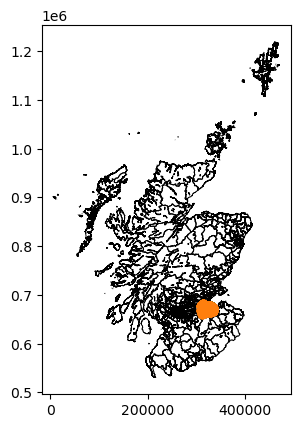

In [33]:
gdf2=gpd.read_file('DataShapefiles\SG_IntermediateZone_Bdry_2011.shp')
gdf2.crs
ax=gdf1.plot()
gdf2.plot(ax=ax, facecolor="none", edgecolor='black', lw=0.7)
gdf_sel=gdf1.sjoin(gdf2,how='inner',predicate='within')
print(gdf_sel.shape)
gdf_sel.plot(ax=ax)


In [147]:
df_lookup=pd.read_csv('Data/DataZone2011lookup.csv')
print(df_lookup.columns)
DZIZ_lookup_edinburgh=df_lookup[df_lookup['LA_Name'].str.contains('City of Edinburgh')]['IZ2011_Code'].unique().tolist()
print(len(DZIZ_lookup_edinburgh))

Index(['DZ2011_Code', 'DZ2011_Name', 'IZ2011_Code', 'IZ2011_Name', 'LA_Code',
       'LA_Name'],
      dtype='object')
111


In [165]:
#you see it reading the shapefile very slowly
#lets output the shapefile to parquet for faster reading next time
print(gdf2[gdf2['InterZone'].isin(DZIZ_lookup_edinburgh)].shape)
gdf2[gdf2['InterZone'].isin(DZIZ_lookup_edinburgh)].to_parquet("output_data5/SG_IntermediateZone_Bdry_2011Edinburgh.parquet")



(111, 8)


## Spatial Joins in DuckDB

We now demonstrate how **spatial joins** are performed in DuckDB.

As described earlier, we first create **point geometries** from the latitude and longitude values of the Airbnb listings.  
These geometries are then projected to the **British National Grid (EPSG:27700)** to ensure compatibility with UK-based spatial analysis.

In addition, temporal fields are cleaned and converted into appropriate date formats.  
This prepares the data for time-based aggregation and analysis in later steps.


In [166]:
# con.sql("""drop table TestSwap; """)
con.sql("""
    Create table if not exists listings_proj as(
        SELECT 
                ST_Transform(ST_GeomFromText(cast(ST_Point(latitude, longitude) as Text)),'epsg:4326','epsg:27700') AS geometry,  
                CAST(CAST(last_scraped AS DATE) as VARCHAR) AS timestemp_date,
                id,        
            FROM listings
        )""")
con.sql ("""select geometry, id,timestemp_date FROM listings_proj limit 3""")


┌──────────────────────────────────────────────┬───────┬────────────────┐
│                   geometry                   │  id   │ timestemp_date │
│                   geometry                   │ int64 │    varchar     │
├──────────────────────────────────────────────┼───────┼────────────────┤
│ POINT (325942.7957244978 674400.0705191917)  │ 15420 │ 2020-12-19     │
│ POINT (331615.7940829449 672665.4645382691)  │ 38628 │ 2020-12-31     │
│ POINT (325497.76564809796 672318.1912047509) │ 44009 │ 2020-12-19     │
└──────────────────────────────────────────────┴───────┴────────────────┘

In [167]:
con.sql("""show tables""")
con.sql("""select count(*) from listings_proj""")

┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│       319304 │
└──────────────┘

We load the Intermediate Zone shapefile making sure the geometry is loaded using **ST_GeomFromText** after reading them as text. </br>
Note that the shapefile is already in British National Grid.
We keep *HHCNt2011* which is the total number of households and skip other fields when create the IZs_gen table. 

In [168]:
con.sql("""SELECT ST_GeomFromText(cast(geometry as Text)) as geometry from 'output_data5/SG_IntermediateZone_Bdry_2011Edinburgh.parquet' limit 3""")

┌───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [170]:

con.sql("""drop table my_database_exercise.IZs""")

con.sql("""
CREATE TABLE my_database_exercise.IZs AS
SELECT *
FROM 'output_data5/SG_IntermediateZone_Bdry_2011Edinburgh.parquet'
""")

con.sql("""describe my_database_exercise.IZs""")

con.sql("""SELECT * from my_database_exercise.IZs limit 3""")

con.sql("""SELECT count(*) from my_database_exercise.IZs limit 3""")



┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│          111 │
└──────────────┘

In [172]:
##you can select certain fields and save it to another table
con.sql("""DROP TABLE IF EXISTS my_database_exercise.IZs_Gen""")

con.sql("""
    CREATE TABLE my_database_exercise.IZs_Gen AS
    SELECT
        ST_GeomFromText(CAST(geometry AS TEXT)) AS geometry,
        Name,
        HHCnt2011
    FROM IZs
""")

con.sql("""
    SELECT geometry, Name
    FROM my_database_exercise.IZs_Gen
    LIMIT 3
""")


┌───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

The created IZ_Gen can be visulized either using GeoPandas plot function or Leapmap. 

<Axes: >

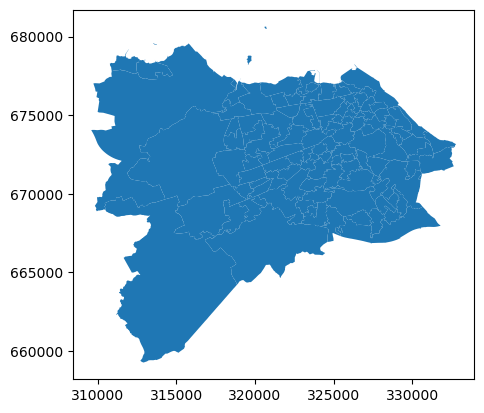

In [173]:


df_iz=con.sql("SELECT * exclude geometry, st_asText(geometry) as geometry FROM IZs_Gen").df()
df_iz.head()
df_iz['geometry'] = gpd.GeoSeries.from_wkt(df_iz['geometry'])
gdf_iz=gpd.GeoDataFrame(df_iz, geometry='geometry').set_crs('epsg:27700')
gdf_iz.head()
gdf_iz.to_parquet("output_data5/SG_IntermediateZone_Bdry_2011.parquet")
gdf_iz.plot()


In [58]:
# import leafmap.deckgl as leafmap

# m = leafmap.Map(center=[20, 0], zoom=1.2)
# m.add_gdf(gdf_iz, zoom_to_layer=True,pickable=True)
# m.add_gdf(gdf_sel, zoom_to_layer=True, pickable=True)

# m



## Selecting Listings within Intermediate Zones

We are now ready to identify Airbnb listings that fall within **Intermediate Zones**.

This is achieved using the spatial predicate `ST_Intersects`, which tests whether two geometries share any spatial overlap.  
For a full list of spatial functions supported by DuckDB, see the official documentation:  
👉 https://duckdb.org/docs/extensions/spatial/functions

### Spatial Join Logic

The operation is implemented as a **spatial join** between:
- Airbnb listing point geometries, and
- Intermediate Zone polygon geometries

Unlike an attribute join, this join is defined by a **spatial relationship** rather than a shared key.

The result is a join table in which each listing is linked to the Intermediate Zone it intersects.

### Aggregation

We then count the total number of listings within each Intermediate Zone boundary.

At this stage, it is useful to reflect on the result:
- How does this dataset differ from the original listings table?
- What information has been gained, and what level of detail has been reduced?

These questions help clarify the analytical impact of spatial joins and aggregation.


In [59]:
##could be very slow
con.sql("""
    SELECT
        count(Lsts.id) AS listing_id,
    FROM 
            (SELECT 
            geometry, id        
            FROM listings_proj) as Lsts
        JOIN 
            (SELECT geometry,name, from IZs_Gen) as IZs
    
        ON ST_intersects(Lsts.geometry, IZs.geometry)
    
""")
#WHERE IZs.NAME = 'Kintyre Trail';

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────┐
│ listing_id │
│   int64    │
├────────────┤
│     319142 │
└────────────┘

Instead of count the total valid listings, we can let the join output the listings_id, timestemp_date and IZ.Name. </br>
Note that listing_id and timestemp_date come form listing table (called Lsts now) while IZs comes from Intermediate Zone table (called IZs now). 

In [174]:
con.sql("""      
          Select lsts.id, lsts.timestemp_date, IZs.Name from (
            (SELECT * from listings_proj) as lsts
                JOIN 
            (Select * from IZs_Gen) as IZs                               
            ON ST_intersects(Lsts.geometry, IZs.geometry)     
        ) limit 5
        """)

┌──────────┬────────────────┬──────────────────┐
│    id    │ timestemp_date │       Name       │
│  int64   │    varchar     │     varchar      │
├──────────┼────────────────┼──────────────────┤
│  9042097 │ 2020-12-31     │ Queensferry West │
│  8208763 │ 2020-12-31     │ Queensferry West │
│ 10142027 │ 2021-01-01     │ Queensferry East │
│  4265784 │ 2020-12-31     │ Queensferry East │
│  7706740 │ 2021-01-01     │ Queensferry East │
└──────────┴────────────────┴──────────────────┘

Finally, we can construct a table which contains some more complex calcualations besed on the spatial join table called IZCountLsts. </br>
We count total number of listings and a ratio of listings to total households called listingRatio.</br>
They are aggregated numbers on not only IZs but also month and year. 

Can you tell the overall structure of this query?


In [ ]:
con.sql("""
    WITH IZCountLsts AS (

      Select lsts.id, lsts.timestemp_date , IZs.Name, IZs.HHCnt2011 from 
        (
            (SELECT * from listings_proj) as lsts
                JOIN 
            (Select * from IZs_Gen) as IZs                               
            ON ST_intersects(Lsts.geometry, IZs.geometry)     
        ) limit 5000
    )
SELECT
    count(distinct izcl.id) as listings, 
    monthname(cast(timestemp_date as date)) as month, 
    year(cast(timestemp_date as date)) as year, 
    izcl.Name as intermediateZone, 
    (count(distinct izcl.id)/izcl.HHCnt2011)*100 as listingRatio
FROM
    IZCountLsts as izcl
group by 
    intermediateZone, month,year, HHCnt2011
Order by 
    month,year
;
""")


┌──────────┬──────────┬───────┬──────────────────────────────────────┬──────────────────────┐
│ listings │  month   │ year  │           intermediateZone           │     listingRatio     │
│  int64   │ varchar  │ int64 │               varchar                │        double        │
├──────────┼──────────┼───────┼──────────────────────────────────────┼──────────────────────┤
│       11 │ December │  2020 │ Comiston and Swanston                │   0.4908522980812137 │
│        8 │ December │  2020 │ Currie East                          │   0.6284367635506678 │
│       31 │ December │  2020 │ Trinity                              │   1.4903846153846154 │
│       87 │ December │  2020 │ Broughton North and Powderhall       │   3.9581437670609647 │
│       46 │ December │  2020 │ Newington and Dalkeith Road          │     2.48246087425796 │
│       68 │ December │  2020 │ Meadowbank and Abbeyhill North       │   2.7880278802788028 │
│        6 │ December │  2020 │ Carrick Knowe               

In [176]:
con.sql("""drop table listingGrpMonthly""")

con.sql("""
Create Table listingGrpMonthly as (
    WITH IZCountLsts AS (

      Select lsts.id, lsts.timestemp_date , IZs.Name, IZs.HHCnt2011 from 
        (
            (SELECT * from listings_proj) as lsts
                JOIN 
            (Select * from IZs_Gen) as IZs                               
            ON ST_intersects(Lsts.geometry, IZs.geometry)     
        ) 
    )
SELECT
    count(distinct izcl.id) as listings, 
    monthname(cast(timestemp_date as date)) as month, 
    year(cast(timestemp_date as date)) as year, 
    izcl.Name as intermediateZone, 
    (count(distinct izcl.id)/izcl.HHCnt2011)*100 as listingRatio
FROM
    IZCountLsts as izcl
group by 
    intermediateZone, month,year, HHCnt2011
Order by 
    month,year
)
;""")
# strptime(CAST(integer_date AS VARCHAR), '%Y%m%d')
#limit 5000

con.sql("""select * from listingGrpMonthly""")


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────┬───────────┬───────┬────────────────────────────────────┬─────────────────────┐
│ listings │   month   │ year  │          intermediateZone          │    listingRatio     │
│  int64   │  varchar  │ int64 │              varchar               │       double        │
├──────────┼───────────┼───────┼────────────────────────────────────┼─────────────────────┤
│        6 │ April     │  2021 │ Colinton Mains and Firrhill        │  0.3146303093864709 │
│        6 │ April     │  2021 │ Queensferry West                   │ 0.36719706242350064 │
│       16 │ April     │  2021 │ Longstone and Saughton             │  0.9060022650056626 │
│       48 │ April     │  2021 │ Slateford and Chesser              │  1.8376722817764166 │
│       66 │ April     │  2021 │ Merchiston and Greenhill           │   3.019213174748399 │
│        8 │ April     │  2021 │ Liberton East                      │   0.599250936329588 │
│        7 │ April     │  2021 │ Corstorphine North                 │  0.5434782

### Time-Enabled Spatial Visualisation

To visualise temporal change, we use a time slider map.
This requires:

- Aggregated spatial units
- A single datetime field
- A backend that supports temporal controls

For this reason, we switch from Lonboard to the Folium backend.
This highlights an important trade-off between performance and functionality.


In [177]:
# Drop table if it already exists
con.sql("DROP TABLE IF EXISTS listingGrpMonthly_geo")

# Join aggregated results back to IZ geometries
con.sql("""
CREATE TABLE listingGrpMonthly_geo AS
SELECT
    lgm.*,
    iz.geometry
FROM listingGrpMonthly lgm
JOIN IZs_Gen iz
ON lgm.intermediateZone = iz.name
""")


In [178]:
import geopandas as gpd

df_map = con.sql("""
    SELECT
        * EXCLUDE geometry,
        ST_AsText(geometry) AS geometry
    FROM listingGrpMonthly_geo
""").to_df()

gdf_map = gpd.GeoDataFrame(
    df_map,
    geometry=gpd.GeoSeries.from_wkt(df_map["geometry"]),
    crs="EPSG:27700"
)

gdf_map["listingRatio"] = gdf_map["listingRatio"].astype(float).map("{:.2f}".format)


gdf_map.head()


,listings,month,year,intermediateZone,listingRatio,geometry
0,6,April,2021,Colinton Mains and Firrhill,0.31,"POLYGON ((322745 669872, 322770 669853.999, 32..."
1,6,April,2021,Queensferry West,0.37,"POLYGON ((311772.1 678781.7, 311782.5 678739, ..."
2,16,April,2021,Longstone and Saughton,0.91,"POLYGON ((321259 671521, 321262 671485, 321391..."
3,48,April,2021,Slateford and Chesser,1.84,"POLYGON ((322662 671968, 322706 671843, 322716..."
4,66,April,2021,Merchiston and Greenhill,3.02,"POLYGON ((324982 672127, 324954 672122, 324948..."


In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output

def plot_month(year, month, k=5):
    clear_output(wait=True)

    subset = gdf_map[
        (gdf_map["year"] == year) &
        (gdf_map["month"] == month)
    ]


    if subset.empty:
        print(f"No data available for {month} {year}")
        return

    m = leafmap.Map(center=[56.8, -4.9], zoom=6)

    m.add_gdf(
        subset,
        column="listingRatio",
        cmap="Reds",
        classification="naturalbreaks",
        k=k,
        legend_title=f"Listings per 100 households ({month} {year})",

 
    )

    display(m)

widgets.interact(
    plot_month,
    year=sorted(gdf_map["year"].unique()),
    month=sorted(gdf_map["month"].unique()),
    k=widgets.IntSlider(min=3, max=7, step=1, value=5)
)



interactive(children=(Dropdown(description='year', options=(np.int64(2020), np.int64(2021), np.int64(2022), np…

<function __main__.plot_month(year, month, k=5)>

Finally, we close the connection the our DB. 

In [19]:
con.close()

# Some final reflections
We illustrate a workflow which uses two geographical datasets to generate more information. </b>
The workflow is developed in DuckDB. </b>
The output has been stored in a table which will be used by a text-as-query application. </b>

Now, it is your turn for some exercises. </b>
Please 
* use the provided Edinburgh listing data and update SQL accordingly
* use the same data to calculate **listing per KM area** for each intermediate zone per month year;
* show a map of the latest one month **listing per KM area** value




# Exercise (optional)

- Build a building database based on Google-Microsoft-OSM Google-Microsoft-OSM Open Buildings - combined by VIDA - https://source.coop/vida/google-microsoft-osm-open-buildings/geoparquet/by_country

- Find Avg Building size per Intermediate zone in Edinburgh

### Hint

##there is an example of accessing remote data source
##UK's buildings Google-Microsoft-OSM Open Buildings - combined by VIDA - https://source.coop/vida/google-microsoft-osm-open-buildings/geoparquet/by_country
url = "s3://us-west-2.opendata.source.coop/vida/google-microsoft-osm-open-buildings/geoparquet/by_country/country_iso=GBR/GBR.parquet"
# url='https://data.source.coop/vida/google-microsoft-osm-open-buildings/geoparquet/by_country/country_iso=GBR/GBR.parquet'
con.sql(f"SELECT * FROM '{url}' LIMIT 10")
con.sql(f"SELECT count(*) FROM '{url}'")

In [ ]:
con.sql('select * from duckdb_extensions();')

con.install_extension('spatial')
con.load_extension('spatial')

In [ ]:
# Define bounding box for Colorado (approximate)
min_lon, max_lon = -3.5, -3.0
min_lat, max_lat = 55.9, 56.1

# Create a table for the region's buildings
con.sql(
    f"""
CREATE TABLE IF NOT EXISTS buildings AS
SELECT
    geometry,
    ROUND(ST_Area(ST_Transform(geometry, 'EPSG:4326', 'EPSG:27700', true)), 2) as area_sq_meters
FROM read_parquet('{url}')
WHERE bbox.xmin >= {min_lon} AND bbox.xmax <= {max_lon}
  AND bbox.ymin >= {min_lat} AND bbox.ymax <= {max_lat}
"""
)

In [ ]:
con.sql("COPY buildings TO 'output_data5/buildings.parquet'")

import leafmap
# Sample 10,000 buildings for visualization
sample_gdf = con.sql(
    """
SELECT area_sq_meters, ST_AsText(geometry) as geometry
FROM buildings
USING SAMPLE 10000
"""
).df()

# Convert to GeoDataFrame
gdf = leafmap.df_to_gdf(sample_gdf, src_crs="EPSG:4326")

In [ ]:
# Visualize the building sample
m = leafmap.Map(center=[56.8, -4.2], zoom=6)
m.add_data(
    gdf,
    column="area_sq_meters",
    cmap="RdYlGn",
    legend_title="Building Area (m²)",
    fit_bounds=False,
)
m